# Perceptron Lab
## January 2022
### Overview: Manual implementation of a perceptron class
### Note: At this point I did not know how to properly use pandas dataframes

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd

## 1. (40%) Correctly implement and submit your own code for the perceptron learning algorithm. 

### Code requirements
- Shuffle the data each epoch.
- Use Stochastic/On-line training updates: Iterate and update weights after each training instance (i.e. do not attempt batch updates)
- Implement a stopping criterion: when your model has trained for a number of epochs with no significant improvement in accuracy, stop training. Note that the weights/accuracy do not usually change monotonically.
- Use your perceptron to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your perceptron on the Evaluation data with the same parameters, and print your final weights and accuracy.

In [2]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle

    def fit(self, x, Y, initial_weights=None,Cap=np.inf,to_score=False,score_inp=None,score_out=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
            Cap (int or np.inf): Cap on the number of epochs allowed
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        #copying and initializing weights, inputs, and targets so as not to change the originals
        self.weights = self.initialize_weights(x) if initial_weights is None else initial_weights.copy()
        X = x.copy()
        y = Y.copy()
        
        #appending 1 to the inputs
        ones = np.ones((X.shape[0],1))
        X = np.concatenate((X,ones),axis=1)
        
        #making sure dimensions of inputs and weights match
        length = len(X[0])
        if length != len(self.weights):
            raise ValueError("Number of inputs per list does not match number of weights:: "
                             "len(X[0]) = "+str(len(X[0]))+ ", len(weights) = "+str(len(self.weights)))
            
        #making sure number of input lists match number of targets
        elif len(X) != len(y):
            raise ValueError("Number of input lists does not match number of targets:: "
                             "len(X) = " + str(len(X))+ ", len(y) = " + str(len(y)))
            
        #making sure number of inputs for each input list match (inp is short for input)
        for inp in X:
            if len(inp) != length:
                raise ValueError("Number of inputs inconsistent")
        
        #initializing a boolean list for results
        results = [False]*len(y)
        
        #counting number of times previous and changed weights are close and number of iterations
        close = 0
        self.itr = 0
        
        #storing array of missclassification per epoch
        if to_score:
            self.missclass = []
        
        #running algorithm
        while not all(results):
            self.itr += 1
            
            #appending missclassification for this iteration
            if to_score:
                self.missclass.append(1 - self.score(score_inp,score_out))
            
            #checking if iteration is greater than allowed
            if self.itr > Cap:
                self.itr -= 1
                print("cap reached, breaking")
                break
            
            #restarting each time at all false
            results = [False]*len(y)
            
            #copying weights for later comparison
            wcopy = self.weights.copy()
            
            for i,inp in enumerate(X):
                #for each list of inputs, dot with weights; check threshhold 
                net = np.dot(inp,self.weights)
                
                if  net > 0.:
                    out = 1.
                else: 
                    out = 0.
                
                #if target achieved, switch corresponding boolean in results to True
                if out == y[i]:
                    results[i] = True
                    
                #altering weights using delta rule if target not achieved
                else:
                    for j in range(len(self.weights)):
                        delta = self.lr*(y[i] - out)*inp[j]
                        self.weights[j] += delta
                        
            #checking if the weights have changed little; breaking after the tenth epoch in which this is the case
            if np.linalg.norm(np.array(wcopy) - np.array(self.weights)) < 0.375: 
                close += 1
                if close == 10:
                    print("weights changing very little, breaking; epoch =",self.itr)
                    break
            else: close = 0
            
            #shuffling
            if not all(results):
                if self.shuffle:
                    X,y = self._shuffle_data(X,y)
        
        #appending final missclassification score
        if to_score:
                self.missclass.append(1 - self.score(score_inp,score_out))
                self.missclass = np.array(self.missclass)
        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        nets = np.array([np.dot(np.concatenate((arr,np.ones(1))), self.weights) for arr in X])
        nets = np.where(nets>0,1,0)
        return nets, len(nets)

    def initialize_weights(self,X):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """

        return [0]*(len(X[0])+1)

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        #prediction for X, preds is array of 0s and 1s
        preds,n = self.predict(X)
        avg = 0
        
        #the abs difference between preds and y are 0s and 1s; 0 means success
        diff = np.abs(preds - y)
        for ele in diff:
            if ele == 0:
                avg+= 1
        
        return avg/n

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        #combining arrays and shuffling
        Z = np.vstack((X.T,y)).T
        np.random.shuffle(Z)
        
        #extracting X and y
        X = Z[:,:-1]
        y = Z[:,-1]
        
        return X, y

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1\
Deterministic = 10 [i.e., run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Initial Weights = All zeros

---

### 1.1.1 Debug

Debug your model by running it on the [debug dataset](https://byu.instructure.com/files/4421290/download?download_frd=1)

Expected Results:

Accuracy = [0.88]\
Final Weights = [-0.23  0.18 -0.1 ]

In [4]:
# Load debug data
data = arff.loadarff('linsep2nonorigin.arff')
df = pd.DataFrame(data[0])

#reading for targets t
t1 = np.array([int(t.decode('utf-8')) for t in df['class']])

#reading for inputs x
x1 = []
for i in range(8):
    xi = [df['a1'][i],df['a2'][i]]
    x1.append(xi)
x1 = np.array(x1)

# Train on debug data
PC1 = PerceptronClassifier(lr=0.1,shuffle=False)
PC1.fit(x1,t1,Cap=10)
    
# Print accuracy and weights
print('accuracy =',PC1.score(x1,t1))
print('weights =',PC1.get_weights())

weights changing very little, breaking; epoch = 10
accuracy = 0.875
weights = [-0.23000000000000004, 0.1799999999999999, -0.1]


In [5]:
x1

array([[-0.4,  0.3],
       [-0.3,  0.8],
       [-0.2,  0.3],
       [-0.1,  0.9],
       [-0.1,  0.1],
       [ 0. , -0.2],
       [ 0.1,  0.2],
       [ 0.2, -0.2]])

### 1.1.2 Evaluation

We will evaluate your model based on it's performance on the [evaluation dataset](https://byu.instructure.com/files/4421294/download?download_frd=1)

In [7]:
# Load evaluation data
data = arff.loadarff("data_banknote_authentication.arff")
df = pd.DataFrame(data[0])

t2 = np.array([int(t.decode('utf-8')) for t in df['class']])

x2 = []
for i in range(1372):
    xi = [df[KEY][i] for KEY in df.keys()[:-1]]
    x2.append(xi)
x2 = np.array(x2)

# Train on evaluation data
PC2 = PerceptronClassifier(lr=0.1,shuffle=False)
PC2.fit(x2,t2,Cap=10)

# Print accuracy and weights
print('accuracy =',PC2.score(x2,t2))
print('weights =',PC2.get_weights())

cap reached, breaking
accuracy = 0.9876093294460642
weights = [-3.80657242, -2.8408210000000014, -3.0719334000000034, -1.4003906000000004, 4.899999999999999]


## 2. (30%) Classifying on linearly separable and non-linearly separable data

### 2.1 Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.



In [8]:
# Create 2 datasets
ds1 = np.array([
    [2/10,1.75/10],
    [2/10,2/10],
    [1/10,2/10],
    [3.5/10,4/10],
    
    [6.75/10,9.25/10],
    [7/10,8/10],
    [8/10,9/10],
    [9/10,1]
])
ds2 = np.array([
    [2/10,1.75/10],
    [6.75/10,9.25/10],
    [2/10,2/10],
    [7/10,8/10],
    [1/10,2/10],
    [8/10,9/10],
    [3.5/10,4/10],
    [9/10,1]
])
#creating targets
ts = np.array([0,0,0,0,1,1,1,1])

### 2.2 Train on both sets with your perceptron code (with LR=.1)

In [9]:
# Train on each dataset
#creating two perceptrons and training them respectively
PC3 = PerceptronClassifier(shuffle=False)
PC3.fit(ds1,ts)
PC4 = PerceptronClassifier(shuffle=False)
PC4.fit(ds2,ts,Cap=20)

weights changing very little, breaking; epoch = 10


PerceptronClassifier(shuffle=False)

### 2.3 Graph the datasets and their corresponding decision line
 
 - Graph each dataset
 - Use your trained perceptrons above to determine each dataset's decision line
 - For all graphs always label the axes!
 
![Linearly Separable Data](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/linearly_separable.png)

![Not Linearly Separable](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/not_linearly_separable.png)

In [10]:
#Extracting individual weights
W = PC3.get_weights()
w1 = W[0]
w2 = W[1]
w3 = W[2]

#Using the weights to form a linear separator
m = -w1/w2
b = -w3/w2
f = lambda x: m*x + b

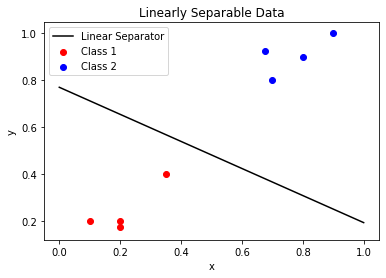

In [11]:
# Graph dataset as points (inputs)
plt.scatter(ds1.T[0,:4],ds1.T[1,:4],color='r',label="Class 1")
plt.scatter(ds1.T[0,4:],ds1.T[1,4:],color='b',label="Class 2")

#plotting line and labeling
X = np.linspace(0,1,1000)
plt.plot(X,f(X),'k',label="Linear Separator")
plt.title("Linearly Separable Data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [12]:
#Extracting individual weights
W = PC4.get_weights()
w1 = W[0]
w2 = W[1]
w3 = W[2]

#Using the weights to form a linear separator
m = -w1/w2
b = -w3/w2
g = lambda x: m*x + b

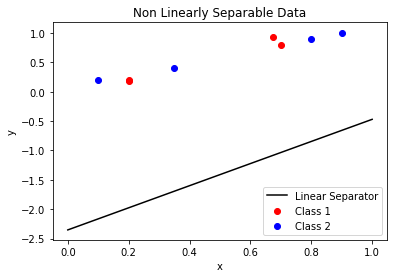

In [13]:
# Graph dataset as points (inputs)
plt.scatter(ds2.T[0,:4],ds2.T[1,:4],color='r',label="Class 1")
plt.scatter(ds2.T[0,4:],ds2.T[1,4:],color='b',label="Class 2")

#plotting line and labeling
plt.plot(X,g(X),'k',label="Linear Separator")
plt.title("Non Linearly Separable Data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 2.4 Discuss why the perceptron won’t converge on non-linearly separable data.

*The perceptron seeks weights such that, for the training data, dotting the weights with the input values outputs a number
that will match the target, usually a 1 if the dot is greater than 0, and a 0 if the dot is less than 0 (this is assuming
a bias has already been incorporated). These weights will describe a line through the data so that on one side of the line, all inputs will output the same value and on the other side of the line the inputs will output the opposite value. The line marks the boundary between the two, meaning on the line, an input will output exactly 0. If the data is linearly separable there exists such a boundary line described by the appropriate weights. All the data that needs to output a 0 will be on the same side of the line, and all the data that needs to output a 1 will be on the other side. If the data is not linearly separable, no such line exists; there is no way to get all the output-1 data on one side and the 0-output on the other. There will always be some error. Thus, since the perceptron seeks this line, when the data is not linearly separable, the perceptron cannot converge to anything that satisfies these demands.*

## 3. (20%) Use your perceptron code to learn this version of the [voting data set](https://byu.instructure.com/files/4421311/download?download_frd=1).

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.  

### 3.1 Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits. 
- Use your own code to randomize and make splits. 
- Report the 5 trials and the average across the 5 trials in a table.  

| Trial | Training Accuracy | Test accuracy | Number of epochs |
| --- | --- | --- | --- |
| 1 | .95 | .55 | 4 |
| 2 | .85 | .45 | 6 |
| Average | .9 | .5 | 5 | 

*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [15]:
#loading the data
data = arff.loadarff("voting-dataset.arff")
df = pd.DataFrame(data[0])

In [16]:
df

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Class
0,b'n',b'y',b'y',b'n',b'n',b'y',b'y',b'y',b'y',b'n',b'y',b'n',b'n',b'y',b'y',b'y',b'democrat'
1,b'n',b'n',b'y',b'y',b'n',b'y',b'y',b'y',b'y',b'y',b'n',b'y',b'n',b'y',b'n',b'y',b'republican'
2,b'n',b'y',b'y',b'n',b'y',b'y',b'n',b'n',b'n',b'n',b'y',b'n',b'y',b'y',b'n',b'n',b'democrat'
3,b'y',b'n',b'n',b'n',b'y',b'y',b'y',b'n',b'n',b'y',b'y',b'n',b'n',b'y',b'n',b'y',b'democrat'
4,b'y',b'y',b'y',b'y',b'y',b'y',b'n',b'n',b'y',b'n',b'y',b'n',b'y',b'y',b'n',b'n',b'democrat'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,b'n',b'n',b'y',b'y',b'y',b'y',b'n',b'n',b'y',b'y',b'n',b'y',b'y',b'y',b'n',b'y',b'republican'
457,b'n',b'n',b'y',b'n',b'n',b'n',b'y',b'y',b'y',b'y',b'n',b'n',b'n',b'n',b'n',b'y',b'democrat'
458,b'n',b'y',b'n',b'y',b'y',b'y',b'n',b'n',b'n',b'n',b'y',b'y',b'y',b'y',b'n',b'y',b'republican'
459,b'n',b'n',b'n',b'y',b'y',b'y',b'y',b'y',b'n',b'n',b'n',b'y',b'y',b'y',b'n',b'y',b'republican'


In [17]:
def Decode(a):
    #decodes the yes and no answers as 1 and 0 respectively
    if a == 'y':
        return 1
    else: return 0

In [18]:
def ClassDecode(a):
    #decodes the republican and democrat answers as 1 and 0 respectively
    if a == 'republican':
        return 1
    else: return 0

In [19]:
#creating answers array (input values)
Answers = []
for i in range(461):
    xi = [Decode(df[KEY][i].decode('utf-8')) for KEY in df.keys()[:-1]]
    Answers.append(xi)
Answers = np.array(Answers)

#creating class array (the targets)
Class = np.array([ClassDecode(t.decode('utf-8')) for t in df['Class']])

In [20]:
def Randomize():
    """this function copies the answers and class arrays, shuffles, and returns a 70/30 split for training and testing"""
    ACopy = Answers.copy()
    CCopy = Class.copy()
    
    #combining arrays and shuffling
    Z = np.vstack((ACopy.T,CCopy)).T
    np.random.shuffle(Z)
    #extracting Answers and Class
    ACopy = Z[:,:-1]
    CCopy = Z[:,-1]
    
    #Splitting 70/30
    ATrain = ACopy[:322]
    CTrain = CCopy[:322]
    ATest  = ACopy[322:]
    CTest  = CCopy[322:]
    
    return ATrain, CTrain, ATest, CTest

In [21]:
# Create the table any way you like
d = {'Trial':[],'Training Accuracy':[],'Test Accuracy':[],'Number of Epochs':[]}
V_Weights = []
missclass = []

for i in range(1,6):
    #get random 70/30 splits of the answers and classes
    ATrain, CTrain, ATest, CTest = Randomize()
    
    #training on the 70 splits
    PC5 = PerceptronClassifier(shuffle=False)
    PC5.fit(ATrain,CTrain,to_score=True,score_inp=ATest,score_out=CTest)
    missclass.append(PC5.missclass)
    
    #appending list of weights to total weights list
    V_Weights.append(PC5.get_weights())
    
    #reporting trial number, training score, testing score, and number of epochs to dictionary
    d['Trial'].append(i)
    d['Training Accuracy'].append(PC5.score(ATrain,CTrain))
    d['Test Accuracy'].append(PC5.score(ATest,CTest))
    d['Number of Epochs'].append(PC5.itr)
    
#turning voting weights and missclassification to arrays
V_Weights = np.array(V_Weights)
missclass = np.array(missclass,dtype=object)

#getting averages
d['Trial'].append("Average")
d['Training Accuracy'].append(np.mean(d['Training Accuracy']))
d['Test Accuracy'].append(np.mean(d['Test Accuracy']))
d['Number of Epochs'].append(np.mean(d['Number of Epochs']))
for i in range(len(d['Number of Epochs'])):
    d['Number of Epochs'][i] = int(d['Number of Epochs'][i])

weights changing very little, breaking; epoch = 89
weights changing very little, breaking; epoch = 460
weights changing very little, breaking; epoch = 30
weights changing very little, breaking; epoch = 37
weights changing very little, breaking; epoch = 22


In [22]:
#This cell of code orders the subarrays of 'missclass' from greatest length to least. 
#Then averages each trial's missclassification error at each epoch

inds = np.flip(np.argsort([len(subarray) for subarray in missclass]))
missclass = missclass[inds]

#ordering the lengths from greatest to least
mc0,mc1,mc2,mc3,mc4 = len(missclass[0]),len(missclass[1]),len(missclass[2]),len(missclass[3]),len(missclass[4])
avgs = []
for i in range(mc0):
    #while there is data at index i in each subarray, sum it with its fellows and average appropriately
    if i<mc1 and i<mc2 and i<mc3 and i<mc4:
        avg = (missclass[0][i] + missclass[1][i] + missclass[2][i] + missclass[3][i] + missclass[4][i]) / 5
    elif i<mc1 and i<mc2 and i<mc3:
        avg = (missclass[0][i] + missclass[1][i] + missclass[2][i] + missclass[3][i]) / 4
    elif i<mc1 and i<mc2:
        avg = (missclass[0][i] + missclass[1][i] + missclass[2][i]) / 3
    elif i<mc1:
        avg = (missclass[0][i] + missclass[1][i]) / 2
    else:
        avg = missclass[0][i]
    avgs.append(avg)

In [23]:
#creating dataframe of accuracies and epoch numbers
DF = pd.DataFrame(data=d)
DF = DF.set_index("Trial")
DF

,Training Accuracy,Test Accuracy,Number of Epochs
Trial,,,
1,0.972050,0.956835,89
2,0.959627,0.949640,460
3,0.962733,0.956835,30
4,0.913043,0.841727,37
5,0.965839,0.935252,22
Average,0.954658,0.928058,127


In [24]:
#populating a dictionary to hold the weights assigned to each feature
W_Dict = dict()
for i,key in enumerate(df.keys()):
    if i != 16:
        W_Dict[key] = np.concatenate( (V_Weights.T[i],  np.array([np.mean(V_Weights.T[i])]) ))

In [25]:
#Creating a dataframe showing weights for each feature for each trial, and the average across all five trials
WDF = pd.DataFrame(data=W_Dict)
WDF = WDF.set_index(pd.Index([1, 2, 3, 4, 5, "Average"]))
WDF

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
1,0.10,0.10,-1.00,2.00,0.60,2.775558e-17,0.20,1.0,-0.80,0.20,-1.0,-2.000000e-01,0.10,-0.10,-0.4,0.90
2,-0.20,-0.60,-1.10,2.80,-0.10,3.000000e-01,0.20,1.7,-1.30,1.00,-1.1,1.000000e-01,0.30,0.20,-1.6,0.40
3,0.20,-0.10,-0.80,2.20,0.70,-2.775558e-17,1.00,0.5,-1.20,0.70,-1.2,-1.000000e-01,0.20,0.20,-0.5,0.30
4,-0.20,-0.40,-0.60,1.50,0.50,-2.000000e-01,0.60,0.7,-0.40,0.60,-0.6,2.775558e-17,0.20,0.20,-0.6,0.40
5,-0.10,-0.40,-1.20,1.80,-0.10,-2.000000e-01,0.60,1.1,-0.40,0.10,-0.6,1.000000e-01,0.30,-0.10,-0.4,0.20
Average,-0.04,-0.28,-0.94,2.06,0.32,-2.000000e-02,0.52,1.0,-0.82,0.52,-0.9,-2.000000e-02,0.22,0.08,-0.7,0.44


### 3.2 By looking at the weights, explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


*According to the dataframe of the weights, the most critical features for voting are physician fee freeze, synfuels corporation cutback, adoption of the budget resolution, aid to Nicaraguan contras, mx missile, and duty-free exports.
The least critical are crime, religious groups in schools, education spending, handicapped infants, water project cost sharing, superfund right to sue, and export administration act south Africa.*

### 3.3 Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across your 5 trials (not across 5 epochs).


![Average Misclassification Rate](https://raw.githubusercontent.com/rmorain/CS472-1/master/images/perceptron/avg_misclassification_rate_vs_epochs.png)

In [26]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()
    


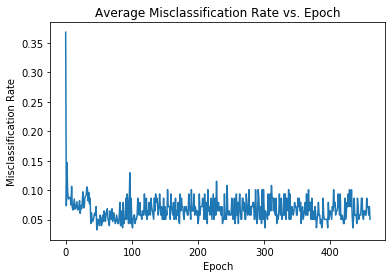

In [27]:
plot_misclassification(avgs)

## 4.1 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above.
- Report and compare your results with your own perceptron code.

In [28]:
#my perceptron's weights
PC6 = PerceptronClassifier(shuffle=False)
PC6.fit(Answers,Class,Cap=20)

print("Accuracy =",PC6.score(Answers,Class))

cap reached, breaking
Accuracy = 0.9739696312364425


In [29]:
# Load sklearn perceptron
SciPer = Perceptron()

# Train on voting dataset
SciPer.fit(Answers,Class)
print("Accuracy =",SciPer.score(Answers,Class))

Accuracy = 0.9609544468546638


*At 20 epochs, my perceptron class is about 1% more accurate than scipy's when trained on the entire data set.*

## 4.2 (5%) Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn one other data set of your choice.
- Try out some of the hyper-parameters that scikit-learn makes available.

In [30]:
# Load sklearn perceptron
ScP = Perceptron(shuffle=False,eta0=0.1)

# Train on your dataset - LOADING EVALUATION DATA SET FROM EARLIER
# Load evaluation data
data = arff.loadarff("data_banknote_authentication.arff")
df = pd.DataFrame(data[0])

t2 = np.array([int(t.decode('utf-8')) for t in df['class']])

x2 = []
for i in range(1372):
    xi = [df[KEY][i] for KEY in df.keys()[:-1]]
    x2.append(xi)
x2 = np.array(x2)

# Train on evaluation data
PC2 = PerceptronClassifier(lr=0.1,shuffle=False)
PC2.fit(x2,t2,initial_weights=[1,1,1,1,1],Cap=10)

# Print my accuracy and weights
print('my accuracy =',PC2.score(x2,t2))
print('my weights =',PC2.get_weights())

#print their accuracy and weights
ScP.fit(x2,t2)
print('their accuracy =',ScP.score(x2,t2))
print('their weights =',ScP.coef_, ScP.intercept_)

cap reached, breaking
my accuracy = 0.9832361516034985
my weights = [-4.16460197, -2.987832000000003, -2.853989000000003, -1.4684300999999997, 5.099999999999999]
their accuracy = 0.9766763848396501
their weights = [[-4.28857497 -2.390381   -3.0160324  -1.1686672 ]] [5.2]


*My goal was to see how closely my code and scipy's perceptron class could mimic each other if given very similar parameters. For the scipy perceptron, I gave hyperparamters of changing the default shuffle=True to False and made my own shuffle false. I also gave it the same learning rate, eta0, of 0.1. Then I modified my own parameters to have initial weights of ones since that is what scipy's does. The accuracy and weights are actually quite close, the biggest difference between the weights being ~0.6 for the second weight.*

## 5. (Optional 5% extra credit) Use the perceptron rule to learn the [iris task](https://byu.instructure.com/files/4421369/download?download_frd=1) or some other task with more than two possible output values. 

Note that the [iris data](https://byu.instructure.com/files/4421369/download?download_frd=1) set has 3 output classes, and a perceptron node only has two possible outputs.  You could implement either of the two most common ways to deal with this. For testing you just execute the novel instance on each model and combine the overall results to see which output class wins.

In [31]:
#loading data
iris = arff.loadarff("iris.arff")
dfi = pd.DataFrame(iris[0])

In [32]:
dfi

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,b'Iris-setosa'
1,4.9,3.0,1.4,0.2,b'Iris-setosa'
2,4.7,3.2,1.3,0.2,b'Iris-setosa'
3,4.6,3.1,1.5,0.2,b'Iris-setosa'
4,5.0,3.6,1.4,0.2,b'Iris-setosa'
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,b'Iris-virginica'
146,6.3,2.5,5.0,1.9,b'Iris-virginica'
147,6.5,3.0,5.2,2.0,b'Iris-virginica'
148,6.2,3.4,5.4,2.3,b'Iris-virginica'


In [33]:
#setosa is 0:50, versicolor is 50:100, virginica is 100:150

In [34]:
#create one perceptron for each output class
PCS = PerceptronClassifier()                     #setosa
PCVe = PerceptronClassifier()                    #versicolor
PCVi = PerceptronClassifier()                    #virginica

#for each perceptron, treat its respective class as 1 outputs and 0 for the others
St = np.concatenate( (np.ones(50), np.zeros(100))  )                    #setosa targets
Vet = np.concatenate(  (np.zeros(50), np.ones(50), np.zeros(50))  )     #Ve targets
Vit = np.concatenate(  (np.zeros(100), np.ones(50))  )                  #Vi targets

#reading inputs
Flowers = []
for i in range(150):
    xi = [dfi['sepallength'][i],dfi['sepalwidth'][i],dfi['petallength'][i],dfi['petalwidth'][i]]
    Flowers.append(xi)
Flowers = np.array(Flowers)

#Run all perceptrons on novel data
PCS.fit(Flowers,St,Cap=200)
PCVe.fit(Flowers,Vet,Cap=200)
PCVi.fit(Flowers,Vit,Cap=200)

#set the output to the class of the perceptron which outputs high
print("\nSetosa Perceptron Score:",PCS.score(Flowers,St))
print("Versicolor Perceptron Score:",PCVi.score(Flowers,Vet))
print("Virginica Perceptron Score:",PCVe.score(Flowers,Vit))

cap reached, breaking
cap reached, breaking

Setosa Perceptron Score: 1.0
Versicolor Perceptron Score: 0.36666666666666664
Virginica Perceptron Score: 0.5133333333333333
